In [1]:
import scipy
import scipy.integrate as integrate
import numpy as np

#constants
k_b = 1.380649e-23               #boltzman constant
hbar = 1.05457e-34               #reduced plank's constant, h/2*pi
q = 1.60218e-19                  #fundamental charge
mu_0 = 1.256637e-6               #vacuum permeability

###Change theses values for simulation###
# temp = 10e-3                     #temp of device in kelvin
# omega = 2 * np.pi * 6e9          #angular frequency
# t_crit = 4.44                    #critical temp for niobium, kelvin
# normal_cond = 7.42e6             #normal state conductivity
# london_pen_depth = 150e-9        #london penetration depth, lambda_l
# coherence_len = 30e-9            #coherence length, xsi
# delta_0 = 1.4e-3                 #gap energy in eV 
# l = 11.5e-9                      #mean free path

# #calculate quantities needed for numerical integation
# fermi_velocity = np.pi * coherence_len * (delta_0*q) / hbar #fermi velovity, m/s
# mean_free_path = np.pi * mu_0 * (delta_0*q) * london_pen_depth * coherence_len * normal_cond / hbar 
# tau = l / fermi_velocity #scattering time
# delta = (delta_0 * q) * np.sqrt( np.cos((np.pi/2) * (temp/t_crit)**2)) #temperature dependent gap energy - related to the gape nergy at zero temp (delta_0)



In [12]:
#Condition for BCS weakly coupled, ideally should be ~1.76
ratio = (delta_0 * q) / (k_b*t_crit)
print(f"BCS_ratio = {ratio}")

BCS_ratio = 1.7601148195886422


In [30]:
#titanium nitride parameters - for later use
temp = 10e-3                     #temp of device in kelvin
omega = 2 * np.pi * 6e9          #angular frequency
normal_cond = 9.78e4 
london_pen_depth = 250e-9 
coherence_len = 42e-9
delta_0 = 0.317e-3
l = 33e-9 
t_crit = 2.09 

#calculate quantities needed for numerical integation
fermi_velocity = np.pi * coherence_len * (delta_0*q) / hbar #fermi velovity, m/s
mean_free_path = np.pi * mu_0 * (delta_0*q) * london_pen_depth * coherence_len * normal_cond / hbar 
tau = l / fermi_velocity #scattering time
delta = (delta_0 * q) * np.sqrt( np.cos((np.pi/2) * (temp/t_crit)**2))

In [22]:
#niobium parameters
temp = 10e-3                     #temp of device in kelvin
omega = 2 * np.pi * 100e9          #angular frequency
t_crit = 9.2                    #critical temp for niobium, kelvin
normal_cond = 5.5e7             #normal state conductivity
london_pen_depth = 33.3e-9        #london penetration depth, lambda_l
coherence_len = 39e-9            #coherence length, xsi
delta_0 = 1.395e-3                 #gap energy in eV 
l = 20e-9                      #mean free path

#calculate quantities needed for numerical integation
fermi_velocity = np.pi * coherence_len * (delta_0*q) / hbar #fermi velovity, m/s
mean_free_path = np.pi * mu_0 * (delta_0*q) * london_pen_depth * coherence_len * normal_cond / hbar 
tau = l / fermi_velocity #scattering time
delta = (delta_0 * q) * np.sqrt( np.cos((np.pi/2) * (temp/t_crit)**2))

### Numerical Integration

In [27]:
import numpy as np

def bers(x, y, tt):
    """
    Calculation of complex conductivity sigma(q=0, omega) for superconductors
    using BCS-theory.
    
    Input:
        x  = omega / (2 * Delta)
        y  = l / (2 * Delta * tau)
        tt = temperature / Tc
    
    Output:
        s = sigma = sigma1 + i * sigma2
    """
    M = 500
    dl = 1.0 / M
    dx = 1.0 / int(M * max(1.0, np.sqrt(x)))
    doverk = (delta_0*q) / (k_b * t_crit) 
    t = tt / (doverk * 2 * np.sqrt(1 - tt) * (0.9963 + 0.7733 * tt))
    
    sl = 0j
    s2 = 0j
    s3 = 0j
    
    # First integral loop
    u_values = np.arange(dx * 0.5, 1.0 , dx)
    for u in u_values:
        s2 += GK(0.5 + (u/(1 - u) )** 2, x, y, t, 2) * u / ((1 - u) ** 3)
    s = s2 * dx * 2.0
    
    if x < 1:
        for u in u_values:
            sl += GK(0.5 + x * u ** 2 * (3 - u - u), x, y, t, 1) * u * (1 - u)
        s += sl * dx * 6.0 * x
    else:
        for u in u_values:
            s3 += GK(0.5 + (x - 1) * u ** 2 * (3 - u - u), x, y, t, 3) * u * (1 - u)
        #sl = 0j  # Reset sl
        for u in np.arange(dl * 0.5, 1.0 , dl):
            sl += GK(x - 0.5 + u ** 2 * (3 - u - u), x, y, t, 1) * u * (1 - u)
        s += (s3 * dx * (x - 1) + sl * dl) * 6.0
    
    s *= complex(0.0, y) * 0.5 / x
    return s

def GK(e, x, y, t, k):
    """
    Computes the integral function GK for the given parameters.
    """
    cy = complex(0.0, y)
    
    if k == 1:
        p4 = complex(0.0, np.sqrt(0.25 - (e - x) ** 2))
        p2 = np.sqrt(e ** 2 - 0.25)
        c42 = (0.25 + e * (e - x)) / (p4 * p2 + 1e-20)
        th = np.tanh(e / (t + t + 0.001))
        return th * ((1 - c42) / (p4 + p2 + cy) - (1 + c42) / (p4 - p2 + cy))
    
    elif k == 2:
        p1 = np.sqrt((e + x) ** 2 - 0.25)
        p2 = np.sqrt(e ** 2 - 0.25)
        c12 = (0.25 + e * (e + x)) / (p1 * p2 + 1e-20)
        th = np.tanh(e / (t + t + 0.001))
        return (np.tanh((e + x) / (t + t + 0.001)) * ((1 + c12) / (p1 - p2 + cy) - (1 - c12) / (-p1 - p2 + cy))
                + th * ((1 - c12) / (p1 + p2 + cy) - (1 + c12) / (p1 - p2 + cy)))
    
    elif k == 3:
        p3 = np.sqrt((e - x) ** 2 - 0.25)
        p2 = np.sqrt(e ** 2 - 0.25)
        c32 = (0.25 + e * (e - x)) / (p3 * p2 + 1e-20)
        th = np.tanh(e / (t + t + 0.001))
        return th * ((1 - c32) / (p3 + p2 + cy) - (1 + c32) / (p3 - p2 + cy))
    
    return 0j

#Calculate complex conductivity:
x = (hbar * omega) / (2 * delta)
y = hbar / (2*tau*(delta))   # Impurity scattering
tt = temp/t_crit  # T / Tc

sigma = bers(x, y, tt)
print(f"Complex conductivity: σ = {sigma}")

Complex conductivity: σ = (-6.871306300275937e-17+20.697562791550794j)


### Impedance Boundary Condition

In [31]:
d= 40.8e-9
#d= 200e-9
lambda_eff = np.sqrt(1/(mu_0 * omega * sigma.imag * normal_cond))
#lambda_eff = 150e-9
Z = mu_0 * omega * lambda_eff * (1 / np.tanh(d/lambda_eff))
print(f"Surface Impedance: Z = {Z} Ω")
print(f"Surface Inductance: L = {Z/omega} H/□" )
print(f"Effective Penetrattion Depth: λ_eff = {lambda_eff/1e-9} nm")

Surface Impedance: Z = 12.108905266228273 Ω
Surface Inductance: L = 3.2119868809195214e-10 H/□
Effective Penetrattion Depth: λ_eff = 3229.2412199058795 nm


### BCS Formula

In [ ]:
L = hbar * n

### Plotting

In [342]:
import matplotlib.pyplot as plt
x_values = np.arange(0.1, 7 , 0.05)
y_values = [500, 16, 8, 4, 2, 1, 0.5, 0.25, 0.125]
tt = 0
omega = 2*delta /  hbar

sigma = np.zeros((np.size(x_values), np.size(y_values)),dtype=complex)
for i,y in enumerate(y_values):
    for j,x in enumerate(x_values):
        sigma[j,i] = bers(x,y,tt)
        

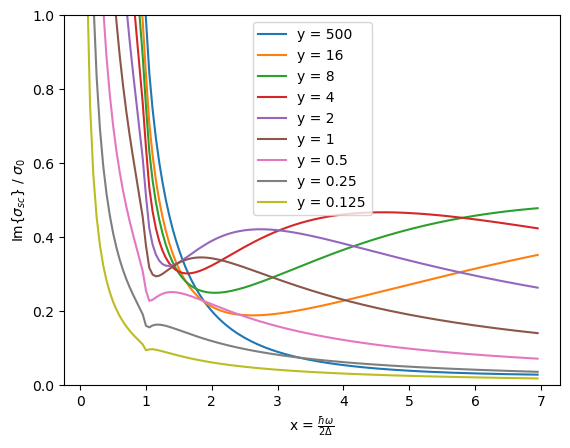

In [360]:
plt.plot(x_values, np.imag(sigma))
plt.ylim(0,1)
plt.xlabel(r'x = $\frac{\hbar \omega }{2 \Delta}$')
plt.ylabel(r'Im{$\sigma_{sc}}$} / $\sigma_{0}$')
plt.legend(['y = 500', 'y = 16', 'y = 8', 'y = 4', 'y = 2', 'y = 1', 'y = 0.5', 'y = 0.25', 'y = 0.125'])
plt.show()

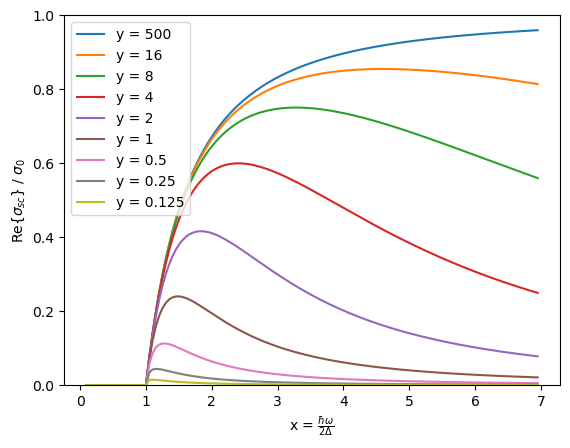

In [359]:
plt.plot(x_values, np.real(sigma))
plt.ylim(0,1)
plt.xlabel(r'x = $\frac{\hbar \omega }{2 \Delta}$')
plt.ylabel(r'Re{$\sigma_{sc}}$} / $\sigma_{0}$')
plt.legend(['y = 500', 'y = 16', 'y = 8', 'y = 4', 'y = 2', 'y = 1', 'y = 0.5', 'y = 0.25', 'y = 0.125'])
plt.show()